In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt


In [5]:
# Load the CSV files
chf_data = pd.read_csv('CHF_exchange_rates.csv')
czk_data = pd.read_csv('CZK_exchange_rates.csv')
eur_data = pd.read_csv('EUR_exchange_rates.csv')
gbp_data = pd.read_csv('GBP_exchange_rates.csv')
usd_data = pd.read_csv('USD_exchange_rates.csv')

In [6]:
# Rename 'rate' columns for clarity
chf_data.rename(columns={'rate': 'CHF_rate'}, inplace=True)
czk_data.rename(columns={'rate': 'CZK_rate'}, inplace=True)
eur_data.rename(columns={'rate': 'EUR_rate'}, inplace=True)
gbp_data.rename(columns={'rate': 'GBP_rate'}, inplace=True)
usd_data.rename(columns={'rate': 'USD_rate'}, inplace=True)

In [7]:
# Merge datasets on the 'date' column
merged_data = chf_data.merge(czk_data, on='date') \
                      .merge(eur_data, on='date') \
                      .merge(gbp_data, on='date') \
                      .merge(usd_data, on='date')

In [8]:
lags = 5
lagged_data = merged_data.copy()
for lag in range(1, lags + 1):
    lagged_data[f'CHF_rate_lag_{lag}'] = lagged_data['CHF_rate'].shift(lag)
    lagged_data[f'CZK_rate_lag_{lag}'] = lagged_data['CZK_rate'].shift(lag)
    lagged_data[f'EUR_rate_lag_{lag}'] = lagged_data['EUR_rate'].shift(lag)
    lagged_data[f'GBP_rate_lag_{lag}'] = lagged_data['GBP_rate'].shift(lag)
    lagged_data[f'USD_rate_lag_{lag}'] = lagged_data['USD_rate'].shift(lag)

# Drop initial rows with NaN values due to lagging
lagged_data.dropna(inplace=True)
# Set target variable as the next day's CHF rate and drop last row due to NaN target
lagged_data['CHF_rate_future'] = lagged_data['CHF_rate'].shift(-1)
lagged_data.dropna(inplace=True)

In [9]:
# Define features and target
X = lagged_data.drop(columns=['date', 'CHF_rate', 'CZK_rate', 'EUR_rate', 'GBP_rate', 'USD_rate', 'CHF_rate_future'])
y = lagged_data['CHF_rate_future']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# TPOT model setup
tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)

# Evaluate model
score = tpot.score(X_test, y_test)
print("Test Score:", score)

# Export the best pipeline code
tpot.export('best_model_pipeline.py')

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.0010598946759311331

Generation 2 - Current best internal CV score: -0.0010598946759311331

Generation 3 - Current best internal CV score: -0.0010456941946455792

Generation 4 - Current best internal CV score: -0.0009860558144116952

Generation 5 - Current best internal CV score: -0.0009645507862561659

Best pipeline: KNeighborsRegressor(StandardScaler(RobustScaler(input_matrix)), n_neighbors=3, p=1, weights=distance)
Test Score: -0.0009319582707748581


In [14]:
# Get predictions on the test set
y_pred = tpot.predict(X_test)

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

Root Mean Squared Error (RMSE): 0.030527991594188737
Mean Absolute Error (MAE): 0.017891326083876273


In [18]:
# Split data into 70% training and 30% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Build the model pipeline using the best TPOT configuration
pipeline = Pipeline([
    ('scaler1', StandardScaler()),
    ('scaler2', RobustScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=3, p=1, weights='distance'))
])

# Train the model on the training data
pipeline.fit(X_train, y_train)

# Evaluate the model on the validation data
y_pred = pipeline.predict(X_val)

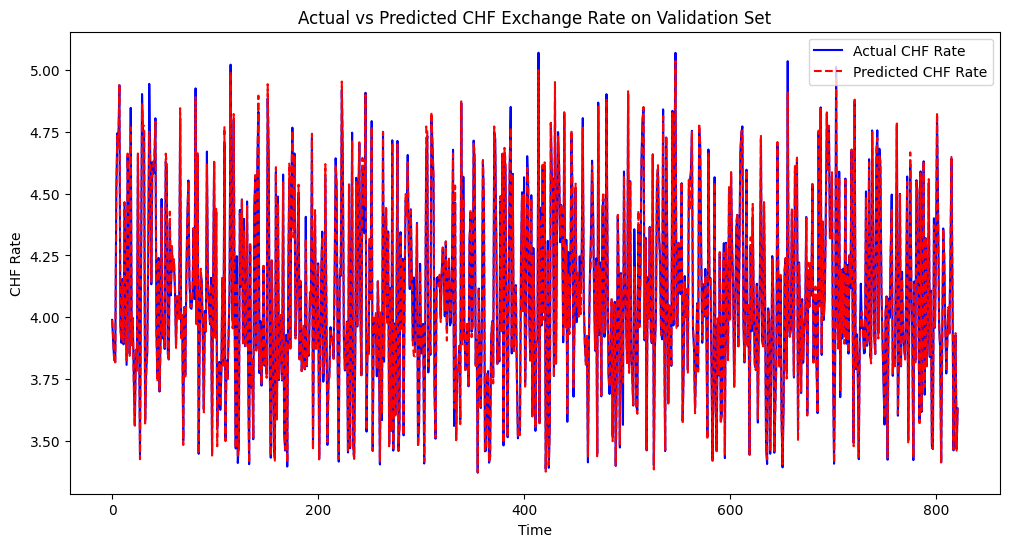

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.values, label='Actual CHF Rate', color='blue')
plt.plot(y_pred, label='Predicted CHF Rate', color='red', linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("CHF Rate")
plt.title("Actual vs Predicted CHF Exchange Rate on Validation Set")
plt.legend()
plt.show()

In [22]:
def k_nearest_neighbors(X, y, n):
    # Split data into training and testing sets (1% for testing as specified)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

    # Initialize the KNeighborsRegressor model
    classifier = KNeighborsRegressor(n_neighbors=n, n_jobs=-1)
    classifier.fit(X_train, y_train)

    # Predict and calculate MSE for the test set
    y_pred = classifier.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred)  # Mean-squared error, test

    # Calculate R^2 score for test set
    test_score = r2_score(y_test, y_pred)

    # Calculate R^2 score for training set
    train_predictions = classifier.predict(X_train)
    train_score = r2_score(y_train, train_predictions)

    # Return RMSE for test set and R^2 scores for train and test sets
    return {'rmse': sqrt(mse_test), 'train': train_score, 'test': test_score}

# Example usage
# Assuming X and y are your feature matrix and target variable
results = k_nearest_neighbors(X, y, n=3)
print("Results:", results)

Results: {'rmse': 0.022960145767193876, 'train': 0.9980779072548642, 'test': 0.9967720648374574}
